<a href="https://colab.research.google.com/github/ImaneElAssari/Prevision-Concentration-Ozone-/blob/master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Previsions de la concentration d'Ozone**

L'objectif de ce modele est de prévoir pour le lendemain un possible dépassement d'un seuil de concentration en Ozone à partir d'une prévision déterministe sur un maillage grossier et de variables climatiques locales.

# Description des donnnées

Cette base de donnees contient les attributs suivantes:


*   **Jour** : Type du jour férié (1) ou pas (0) ;
*   **O3obs**: La concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée 


*  **MOCAGE** : Prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
*   **TEMPE** : Température prévue par MétéoFrance pour le lendemain 17h ;


*   **RMH2O**: Rapport d'humidité ;
*   **NO2** : Concentration en dioxyde d'azote 


*   **NO** : Concentration en monoxyde d'azote ;
*   **STATION** : Lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;


*  **VentMOD** : Force du vent ;
*   **VentANG** : Orientation du vent






In [1]:
import pandas as pd
import numpy as np

In [2]:
#Importation de la dataset
ozone=pd.read_csv("/content/ozone.csv",sep=';')
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
0,1,91,93.2,21.5,0.00847,1.602,0.424,Aix,9.5000,-0.64350
1,1,100,104.6,20.2,0.00881,2.121,0.531,Aix,8.0100,-0.04996
2,0,82,103.6,17.4,0.00951,1.657,0.467,Aix,9.3771,-0.12832
3,0,94,94.8,18.8,0.00855,2.350,0.701,Aix,9.4578,-0.34516
4,0,107,99.0,23.7,0.00731,1.653,0.452,Aix,7.8791,-0.41822


In [3]:
# Determination de la taille de la dataset
ozone.shape

(1041, 10)


**Analyse de Forme**

*   Variable Target : O3obs
*   Lignes : 1041
*   Colonnes : 10
*   Types de variables : Numeriques - Categoriques
*   Missing Values : 0










On affecte le bon type aux variables

la variable jour est represente par des 0 et des 1 et donc pour montrer qu'il s'agit bien d'une variable non quantitative on va utiliser `pandas.Categorical`

In [4]:
ozone["STATION"]=pd.Categorical(ozone["STATION"],ordered=False)
ozone["JOUR"]=pd.Categorical(ozone["JOUR"],ordered=False)
ozone["O3obs"]=pd.DataFrame(ozone["O3obs"], dtype=float)
ozone.dtypes

JOUR       category
O3obs       float64
MOCAGE      float64
TEMPE       float64
RMH2O       float64
NO2         float64
NO          float64
STATION    category
VentMOD     float64
VentANG     float64
dtype: object

Determination des Missing Values

In [5]:
ozone.isna().sum()

JOUR       0
O3obs      0
MOCAGE     0
TEMPE      0
RMH2O      0
NO2        0
NO         0
STATION    0
VentMOD    0
VentANG    0
dtype: int64

In [6]:
ozone.describe()

,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,VentMOD,VentANG
count,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000
mean,115.400576,127.219693,23.883381,0.010251,3.504645,0.657417,5.907186,0.163111
std,40.999155,39.820186,5.217462,0.003731,4.043308,0.844180,3.054307,0.708288
min,19.000000,46.400000,10.400000,0.002850,0.258000,0.001000,0.141420,-1.570790
25%,87.000000,97.500000,20.200000,0.007630,1.248000,0.236000,3.962320,-0.394790
50%,109.000000,125.600000,23.800000,0.009850,2.109000,0.388000,5.597300,0.278300
75%,135.000000,153.600000,27.600000,0.012440,4.062000,0.744000,7.106300,0.692640
max,319.000000,284.700000,38.000000,0.027530,44.396000,9.429000,19.891000,1.570790


#Exploration des données



1.   Unidimensionnelle :



Une varibale quantitative: 

In [7]:
%matplotlib inline

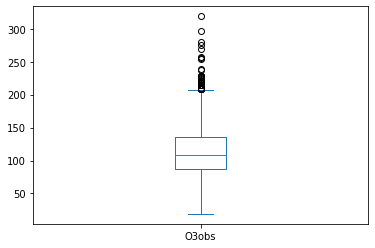

In [8]:
import matplotlib.pyplot as plt
ozone['O3obs'].plot(kind="box")

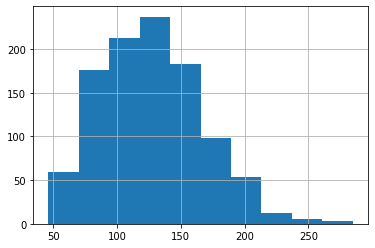

In [9]:
ozone['MOCAGE'].hist()
plt.show()

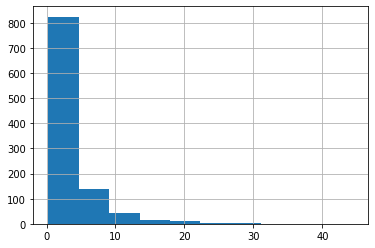

In [10]:
ozone['NO2'].hist()
plt.show()

On va transformer les variables suivantes pour une meilleure utilisation des modèles linéaires.

In [11]:
from math import sqrt, log
ozone["SRMH2O"]=ozone["RMH2O"].map(lambda x: sqrt(x))
ozone["LNO2"]=ozone["NO2"].map(lambda x: log(x))
ozone["LNO"]=ozone["NO"].map(lambda x: log(x))
del ozone["RMH2O"]
del ozone["NO2"]
del ozone["NO"]



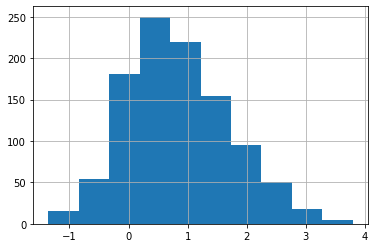

In [12]:
ozone['LNO2'].hist()
plt.show()

On va retirer les variables initiales et construire la variable "dépassement de seuil" pour obtenir le fichier qui sera effectivement utilisé

In [13]:
ozone['DepSeuil']=ozone['O3obs'].map(lambda x: x > 150)
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
0,1,91.0,93.2,21.5,Aix,9.5000,-0.64350,0.092033,0.471253,-0.858022,False
1,1,100.0,104.6,20.2,Aix,8.0100,-0.04996,0.093862,0.751888,-0.632993,False
2,0,82.0,103.6,17.4,Aix,9.3771,-0.12832,0.097519,0.505009,-0.761426,False
3,0,94.0,94.8,18.8,Aix,9.4578,-0.34516,0.092466,0.854415,-0.355247,False
4,0,107.0,99.0,23.7,Aix,7.8791,-0.41822,0.085499,0.502592,-0.794073,False


Une varibale qualitative: 


Pour une variable qualitative, il est important d'identifier des modalités à trop faible effectif ou encore des effectifs très déséquilibrés. Des regroupements peuvent alors être opérés entre les modalatés.

In [14]:
ozone['STATION'].value_counts()

Als    222
Ram    210
Pla    208
Cad    202
Aix    199
Name: STATION, dtype: int64

In [15]:
ozone.STATION.dtypes

CategoricalDtype(categories=['Aix', 'Als', 'Cad', 'Pla', 'Ram'], ordered=False)

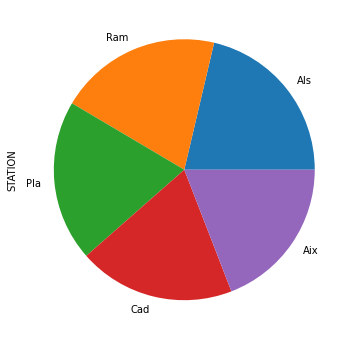

In [16]:
#On veut visualiser les stations sous forme d'un pie Plot
fig, ax = plt.subplots(figsize=(6,6))
ozone["STATION"].value_counts().plot(kind="pie", ax=ax)
plt.show()

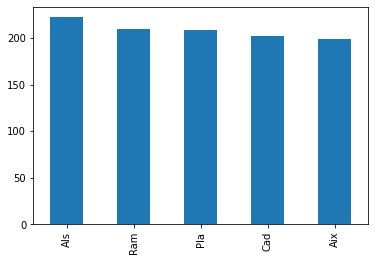

In [17]:
ozone["STATION"].value_counts().plot(kind="bar")
plt.show()



2.   Bidimensionnelle



On va étudier la liaison entre 2 variables.



 *   **Deux variables quantitatives**




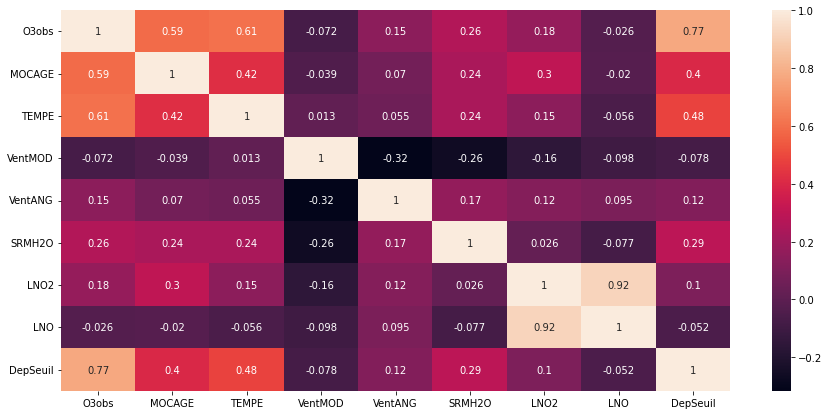

In [18]:
# Matrice de correlation
import seaborn as sns
plt.figure(figsize= (15,7))
correlation_Matrix=ozone.corr()
sns.heatmap(correlation_Matrix,annot=True)
plt.show()

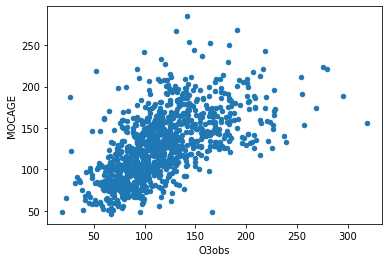

In [19]:
ozone.plot(kind="scatter",x="O3obs",y="MOCAGE")
plt.show()

Cette figure montre qu'il y a une relation lineaire entre les deux variables.

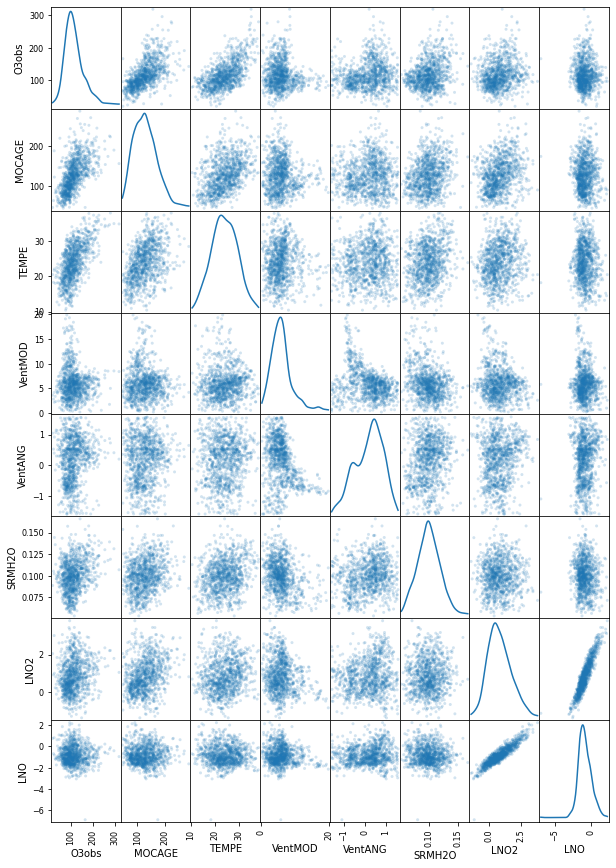

In [20]:
from pandas.plotting import scatter_matrix
scatter_matrix(ozone[["O3obs","MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]], alpha=0.2, figsize=(10, 15), diagonal='kde')
plt.show()

Une variable quantitative et une qualitative

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


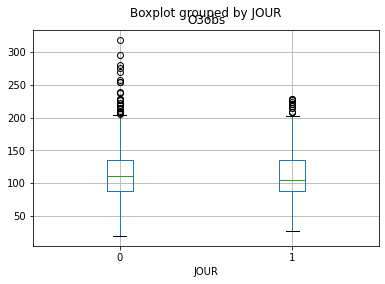

In [21]:
ozone.boxplot(column="O3obs",by="JOUR")
plt.show()

On represente O3obs en fonction des jours fériés (1) et des jours non fériés (0) 

Ce BoxPlot nous demontre l'existance des outliers 

Deux variables qualitatives

On effectue un test dit du  𝜒2, on teste  l'hypothèse  𝐻0 : les variables sont indépendantes. 

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


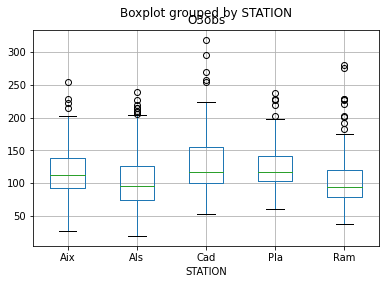

In [22]:
ozone.boxplot(column="O3obs",by="STATION")
plt.show()

In [23]:
table=pd.crosstab(ozone["DepSeuil"],ozone["STATION"])
print(table)

STATION   Aix  Als  Cad  Pla  Ram
DepSeuil                         
False     162  192  149  172  188
True       37   30   53   36   22


Les valeurs False et True determinent les stations inferieur au seuil

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


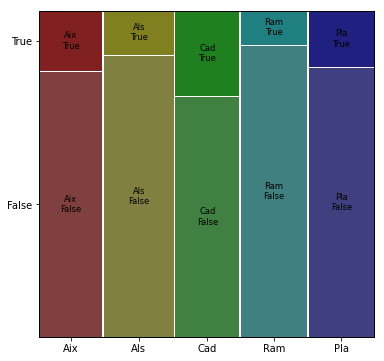

In [24]:
from statsmodels.graphics.mosaicplot import mosaic
# modifier la taille du graphique
fig, ax = plt.subplots(figsize=(6,6))
mosaic(ozone,["STATION", "DepSeuil"], ax=ax)
plt.show()

**Exploration multidimensionnelle de donnees a l'aide d'ACP**

l'Analyse en Composantes Principales permet de prendre une idée précise sur la structure des données.

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
# réduction des variables
X=scale(ozone[["O3obs","MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]])

In [26]:
X

array([[-0.59543433, -0.85474348, -0.45702817, ..., -0.41057249,
        -0.43117052, -0.02079837],
       [-0.3758121 , -0.56831892, -0.70631124, ..., -0.3109154 ,
        -0.10655824,  0.23803517],
       [-0.81505656, -0.59344388, -1.24322861, ..., -0.11162117,
        -0.39212484,  0.09030856],
       ...,
       [-1.01027632,  1.78840252, -1.47333606, ..., -0.51829735,
         1.47842435,  0.89739403],
       [ 0.13663977,  1.62006527, -1.43498482, ..., -0.79536273,
        -0.11751717, -0.89086168],
       [-0.54662939,  2.36125165, -1.37745796, ..., -0.20178351,
        -0.01788028, -0.87365101]])

L'analyse en composantes principales est appliquées seul sur les variables quantitatives.Par ailleurs la variable à modéliser (O3obs, concentration observée) n'est pas utilisée.

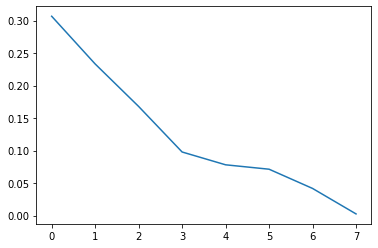

In [27]:
pca = PCA()
## Estimation, calcul des composantes principales
C = pca.fit(X).transform(X)
## Décroissance de la variance expliquée
plt.plot(pca.explained_variance_ratio_)
plt.show()

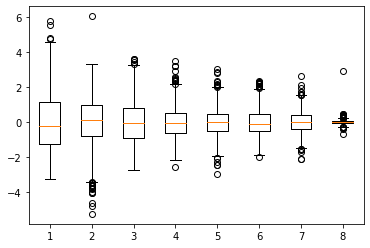

In [28]:
## distribution des composantes principales
plt.boxplot(C)
plt.show()

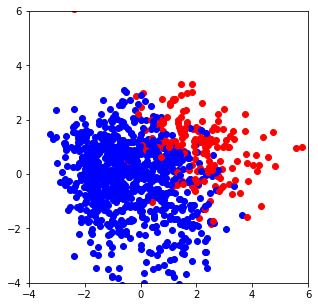

In [29]:
## Repésentation des individus
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], ozone["DepSeuil"]):
    color = "red" if nom  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

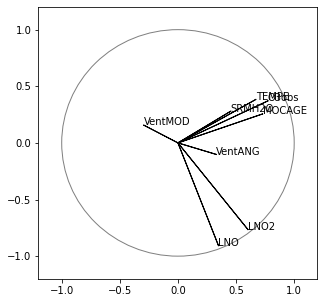

In [30]:
## coordonnées et représentation des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, ozone[["O3obs","MOCAGE","TEMPE","VentMOD",
                                           "VentANG","SRMH2O","LNO2","LNO"]].columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)
plt.show()

# Modélisations:

**Extraction des échantillons apprentissage et test**

In [31]:
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
0,1,91.0,93.2,21.5,Aix,9.5000,-0.64350,0.092033,0.471253,-0.858022,False
1,1,100.0,104.6,20.2,Aix,8.0100,-0.04996,0.093862,0.751888,-0.632993,False
2,0,82.0,103.6,17.4,Aix,9.3771,-0.12832,0.097519,0.505009,-0.761426,False
3,0,94.0,94.8,18.8,Aix,9.4578,-0.34516,0.092466,0.854415,-0.355247,False
4,0,107.0,99.0,23.7,Aix,7.8791,-0.41822,0.085499,0.502592,-0.794073,False


In [32]:
# Transformation de la variable station en dummies
ozoneDum=pd.get_dummies(ozone[["JOUR","STATION"]])
del ozoneDum["JOUR_0"]
#Constitution de la nouvelle dataset qui se compose des valeurs relatives a jour_1 et ud reste des attributs significatives
ozoneQuant=ozone[["MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]]
dfC=pd.concat([ozoneDum,ozoneQuant],axis=1)
dfC.head()

,JOUR_1,STATION_Aix,STATION_Als,STATION_Cad,STATION_Pla,STATION_Ram,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,1,1,0,0,0,0,93.2,21.5,9.5000,-0.64350,0.092033,0.471253,-0.858022
1,1,1,0,0,0,0,104.6,20.2,8.0100,-0.04996,0.093862,0.751888,-0.632993
2,0,1,0,0,0,0,103.6,17.4,9.3771,-0.12832,0.097519,0.505009,-0.761426
3,0,1,0,0,0,0,94.8,18.8,9.4578,-0.34516,0.092466,0.854415,-0.355247
4,0,1,0,0,0,0,99.0,23.7,7.8791,-0.41822,0.085499,0.502592,-0.794073


In [33]:
# variable à expliquer binaire
Yb=ozone["DepSeuil"].map(lambda x: int(x))
# variable à expliquer réelle
Yr=ozone["O3obs"]

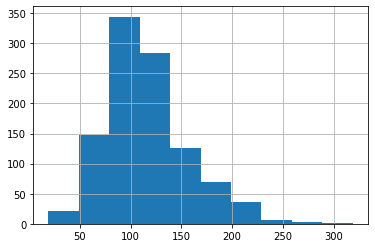

In [34]:
Yr.hist()
plt.show()

Extractions des échantillons d'apprentissage et test pour les deux types de modèles

In [35]:
from sklearn.model_selection import train_test_split  
X_train,X_test,Yb_train,Yb_test=train_test_split(dfC,Yb,test_size=200,random_state=11)
X_train,X_test,Yr_train,Yr_test=train_test_split(dfC,Yr,test_size=200,random_state=11)

L'étape suivante est une étape de standardisation des données ou normalisation. Les variables sont divisées par leur écart-type. Ce n'est pas utile dans le cas d'un modèle linéaire élémentaire car la solution est identique mais indispensbale pour beaucoup d'autres méthodes non linéaires (SVM, réseaux de neurones, modèles avec pénalisation). Cette étape est donc concrètement systématiquement excéutée pour éviter des soucis


**Remarque :**  Les mêmes paramètres (moyennes, écarts-types) estimés sur l'échantillon d'apprentissage sont utilisés pour normaliser l'échantillon test.

In [36]:
from sklearn.preprocessing import StandardScaler  
# L'algorithme ds réseaux de neurones nécessite éventuellement une normalisation 
# des variables explicatives avec les commandes ci-dessous
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.transform(X_train)  
# Meme transformation sur le test
Xr_test = scaler.transform(X_test)
# Mais cela ne semnble pas nécessaire sur ces données.
# Les commandes sont donc fournies à titre indicatif.

# Modéles Simples - Singles

On va estimer la variable DpSeuil (Yb) de type boolean, alors on est face a un probleme de classification.


**1. K-NN**



L'algorithme K plus proches voisins reprérente un cas d'application d'analyses discriminantes non paramétriques. Dans notre cas le paramètre de compléxité (k) est optimisé sur une grille de recherche (Grid Search) prédéfine en minimisant l'erreur estimée par validation croisée.

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
#Optimisation de k en utilisant la grille de valeurs
param_grid=[{"n_neighbors":list(range(1,15))}]
knn=GridSearchCV(KNeighborsClassifier(),param_grid, cv=5,n_jobs=-1)
knnOpt=knn.fit(Xr_train,Yb_train) #GridSearchCV est lui meme un estimateur
#Recherche du parametre optimal
knnOpt.best_params_["n_neighbors"]
print("Meilleur score =%f , Meilleur parametre = %s" % (1. -knnOpt.best_score_,knnOpt.best_params_))

Meilleur score =0.116568 , Meilleur parametre = {'n_neighbors': 7}


In [38]:
#Estimation de l'erreur de prévision sur l'echantillon test
1-knnOpt.score(Xr_test,Yb_test)

0.11499999999999999

88.5% des outputs de ce modeles representent de bonnes predictions.

In [39]:
#Prevision de l'echantillon test
y_chap=knnOpt.predict(Xr_test)
#Matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         163  19
1           4  14


**2. MLP**

Les réseaux neuronaux (perceptron multicouche) font partie des méthodes profondes(Deep Learning).

In [40]:
from sklearn.neural_network import MLPClassifier

In [41]:
param_grid = [{"hidden_layer_sizes":list([(5,),(6,),(7,),(8,)])}]
nnet=GridSearchCV(MLPClassifier(max_iter=500),param_grid,cv=10,n_jobs=-1)
nnetOpt=nnet.fit(Xr_train,Yb_train)
#parametre Optimal
print("Le meilleur score = %f, Le meilleur parametre = %s" % (1-nnetOpt.best_score_,nnetOpt.best_params_))

Le meilleur score = 0.108277, Le meilleur parametre = {'hidden_layer_sizes': (8,)}


In [43]:
#Estimation de l'erreur de prevision sut le test
nnetOpt.score(Xr_test,Yb_test)

0.87

In [44]:
# prevision de l'echantillon test
y_chap = nnetOpt.predict(Xr_test)
# Matrice de confusion 
table = pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         158  17
1           9  16


# Modéles Ensemblistes - Ensembles 

**1. Random Forest**

In [47]:
from sklearn.ensemble import RandomForestClassifier
#definition des parametres
forest = RandomForestClassifier(n_estimators=500, criterion='gini',
                                max_depth=None, min_samples_leaf=1,
                                max_features='auto',max_leaf_nodes=None,
                                bootstrap=True, oob_score=True)
#Apprentissage
rffit = forest.fit(Xr_train,Yb_train)
print(1-rffit.oob_score_)

0.11533888228299638


L'échantillon d'apprentissage a donné un score de 87.87%

In [48]:
#Erreur de prevision sur le test
1-rffit.score(Xr_test,Yb_test)

0.11499999999999999

On veut optimiser ce modele par validation croisée du nombre de varibales tirés aléatoirement lors de la construction de chaque noeud.

In [50]:
param=[{"max_features":list(range(2,10,1))}]
rf=GridSearchCV(RandomForestClassifier(n_estimators=100),
                param , cv=5 , n_jobs=-1)
rfOpt=rf.fit(Xr_train,Yb_train)
#paramètre optimal
print("Meilleur score=%f , Meilleur paramètre=%s" %(1. -rfOpt.best_score_,rfOpt.best_params_))

Meilleur score=0.112983 , Meilleur paramètre={'max_features': 5}


In [52]:
#erreur de prévision sur le test
rfOpt.score(Xr_test,Yb_test)

0.89

Ce modéle donne des prévision avec une précision de 89%

In [54]:
#préviiosn
y_chap=rffit.predict(Xr_test)
#matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         164  20
1           3  13


**2.Boosting - XGBoost**